# Ensemble Analysis

This notebook reads in and formats outputs from ensemble simulations so that you can evaluate and plot

### Import packages

In [79]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os


#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

# Setup static variables

In [80]:
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers
dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # elevation of top layer (import from csv file) (dim: nrow,ncol)

ensembles = [[2,2,2,2,2,2,2], [1,1,2,2,2,2,1]]

# Full ensembles list
# ensembles = [[1,1,2,2,2,2,1],
# [2,2,2,3,1,1,2], 
# [2,2,2,2,2,2,1],
# [2,2,2,2,2,2,3],
# [1,1,3,3,2,2,1],
# [3,3,1,1,2,2,3],
# [3,3,2,2,2,2,3],
# [2,2,2,1,2,2,2],
# [2,2,2,2,3,2,2],
# [2,2,2,2,2,3,2]]

n_ens = len(ensembles)
print(n_ens, 'Ensembles to evaluate')


2 Ensembles to evaluate


## Read in the heads and create timeseries at points

In [81]:
#setup well locations and observation points
#town well
well_loc = (0,21, 38) #town well 
welli_loc = (0,12, 14) #ag irrigation well
farm_cell_loc = (0, 21, 19) # Bottom right corner of the ag field
wello_loc = (0, 15, 15)  # Extra well if you need it

#setup timeseries
head_ts = []  # timeseris of head at town well
farm_mid_ts = []  # timeseries of bottom corner of farm
ag_head_ts = []  # timeseries of head at agg well
mw1_head_ts = []  # timeseries of head at observation well

# Loop through the ensembles and read the data
root_name = 'baseline_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
   
    #Extract out time series of heads at points of interest
    head_ts.append(np.mean(headobj.get_ts(well_loc)))
    farm_mid_ts.append(np.mean(headobj.get_ts(farm_cell_loc)))
    mw1_head_ts.append(np.mean(headobj.get_ts(wello_loc)))
    ag_head_ts.append(np.mean(headobj.get_ts(welli_loc)))
    times = headobj.get_times()
    #print(budgobj.get_unique_record_names())


#### Metric 1: Head gradient between Farm and Town Well

In [82]:
head_dist = 25600

head_change = ((farm_mid_ts-head_ts)/head_dist)
scientific_notation="{:e}".format(head_change)

print("Head Difference (from farm corner) = ", scientific_notation)


Head Difference (from farm corner) =  1.591587e-04
Head Difference (from ag well)=  2.171612e-04


## Store complete gridded outputs as arrays

In [83]:
#setup arrays to store the values
head_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
frf_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
fff_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
recharge_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))
et_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))
stor_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))

# Loop through the ensembles and read the data
root_name = 'baseline_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')   

    rowcounter = -1
    for t in times:
        rowcounter += 1
        head_array[i, rowcounter,:, :, :] = headobj.get_data(totim=t)
        
        tempfrf = np.squeeze(budgobj.get_data(text='flow right face', totim=t))
        frf_array[i, rowcounter,:, :, :] = tempfrf
        
        tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE', totim=t))
        fff_array[i, rowcounter,:, :, :] = tempfff

        temprch = np.squeeze(budgobj.get_data(text='RECHARGE', totim=t))
        recharge_array[i, rowcounter, :, :, :] = temprch[1]

        tempet = np.squeeze(budgobj.get_data(text='ET', totim=t))
        et_array[i, rowcounter, :, :, :] = tempet[1]


#### Metric 2: Depth to water table

In [84]:
WTD = ztop[21,38] - head_ts

print(WTD)

# print(np.ndim(ztop))

[-236.4523  -236.22614]


#### Metric 3: Total Riparian ET

In [85]:
# Create ET variables
et_vals = np.squeeze(et_array)[1,:,:] #This is a matrix of the ET fluxes [m3/day]
rip_ET = et_vals[21:28, :]    # this is a matrix of just the ET fluxes in the riparian area
tot_rip= np.sum(rip_ET)        # Sum of all the riparian fluxes (m3/day)

print("Total Riparian ET =", tot_rip, "m3/day")

## Read in the river leakage

In [86]:
#setup arrays to store the values
leakage_array = np.zeros((len(ensembles), len(times), 49))

# Loop through the ensembles and read the data
root_name = 'baseline_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #water budget files
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')   

    rowcounter = -1
    for t in times:
        rowcounter += 1

        templeak = budgobj.get_data(text='RIVER LEAKAGE', totim=t)
        leakage_array[i, rowcounter,:] = templeak[0].q

# Plot all ensembles together

IndexError: invalid index to scalar variable.

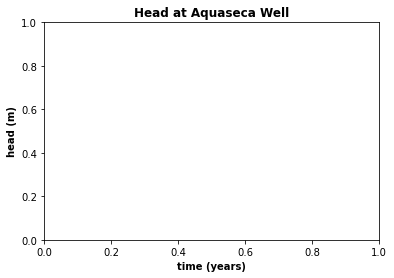

In [89]:
#Head at Aquaseca well 
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
# plt.ylim(75.2,75.8)
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(head_ts[j][:, 0]/360, head_ts[j][:, 1], label=label) #plot the time series with points at each record
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
plt.savefig("Head_Aqua_ensem.png",dpi=600)
plt.show()


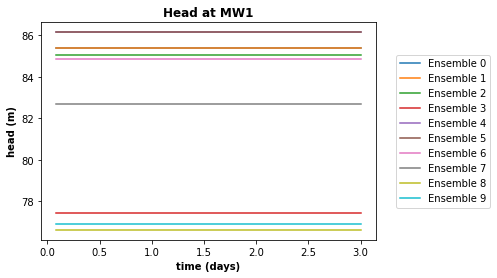

In [ ]:
# Head at observation well
plt.subplot(1, 1, 1)
plt.title("Head at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(mw1_head_ts[j][:, 0]/360, mw1_head_ts[j][:, 1], label=label) #plot the time series with points at each record
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
plt.savefig("Head_M1_ensem.png",dpi=600)
plt.show()

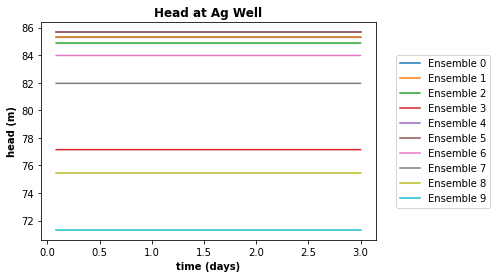

In [ ]:
#Ag Well Plot
plt.subplot(1, 1, 1)
plt.title("Head at Ag Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
for j in range(len(ensembles)):
    label = 'Ensemble ' + str(j)
    plt.plot(ag_head_ts[j][:, 0]/360, ag_head_ts[j][:, 1], label=label) #plot the time series with points at each record

plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
plt.savefig("Head_irri_ensem.png",dpi=600)
plt.show()

## Alternate approach: Read in variables and store as dictionaries

In [ ]:
#setup some structures to store data in 
head = np.tile({}, n_ens)
leakage = np.tile({}, n_ens)
fff = np.tile({}, n_ens)
stor = np.tile({}, n_ens)
recharge = np.tile({}, n_ens)
et = np.tile({}, n_ens)
frf = np.tile({}, n_ens)


# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   
                   
    head[i] = {}
    leakage[i] = {}
    fff[i] = {}
    stor[i] = {}
    recharge[i] = {}
    et[i] = {}
    frf[i] = {}

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')
   
    #store the complete arrays in dictionaries
    for stress_per, time in enumerate(times): #iterate through times at end of each stress period
        head[i]['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
        leakage[i]['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) #append right face flow to frf list for ea stress per
        fff[i]['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
        frf[i]['sp%s'%(stress_per)] = budgobj.get_data(text='flow right face', totim=time)
        stor[i]['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
        recharge[i]['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE', totim=time) 
        et[i]['sp%s'%(stress_per)] = budgobj.get_data(text='ET', totim=time) 